# MeToo, a catalyst for change ? 
## ___Study of the influence of the movement on women's mediatic representation___

*This notebook resumes the work and data-pipeline achieved for Milestone 3, including Milestone 2.*

*The beginning of this Notebook consists in our Milestone 2 notebook, which contains the main methods used to deal with the raw data, process it, and extract the main figures which will let us conduct our analysis. The second part addresses the progress made since the Milestone 2 and analyses in depth the datasets constructed for Milestone 2. This helped us build our datastory.*

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Imports](#Imports)\
        C. [Paths](#Paths)\
</br> 

1. [Step 1: Data scraping, pre-processing and dataset construction](#Step-1)\
        A. [Creation of subset D1 and D2](#creation)\
        B. [Analyse Parquet File](#parquet1)\
        C. [Create datasets - mix Parquet (AD1) and Quotebank](#parquet2)\
        D. [Check datas](#check)\
        E. [Irregularities in data](#irreg)\
</br> 

2. [Step 2: General preliminary analysis using Quotebank entire dataset](#Step-2)\
</br>     

3. [Step 3: Generate annual and monthly word clouds based on general women coverage dataset (D2)](#Step-3)\
</br> 

4. [Step 4: Investigate general women perception via general women coverage in medias (D2)](#Step-4)\
</br>  

5. [Step 5: Investigate gender and generational biases in general women coverage using NLP (D2)](#Step-5)\
</br> 

6. [Step 6: Investigate gender and generational biases in MeToo coverage using NLP (D1)](#Step-6)\
</br>
  
7. [Step 7: Correlate and investigate causation between MeToo general perception and women’s mediatic place](#Step-7)\

---
## General Information <a id="GI"> </a> 

### Folder structure <a id="Folder"> </a>

TODO

***Files and directories to make this notebook run successfully:***

- **data/**
  - **parquet/**
    - *speaker_attributes.parquet*
    - *wikidata_labels_descriptions_quotebank.csv.bz2*
  - **filtered/**
    - **pickles/**
      - *quotes-2020-filtered.pkl.bz2*
    - *quotes-2020-filtered.json.bz2*
  - *quotes-2020.json.bz2*
- *data_processing.ipynb*
- *helper.py*



Directories are in **bold** and files are in *italic*.



### Imports <a id="Imports"> </a>

***Libraries used:***
- python=3.8.12
- pandas
- datetime
- time
- matplotlib
- seaborn
- pickle
- bz2
- json
- nltk
- numpy
- spacy
- sklearn
- re
- plotly
- string


In [ ]:
import bz2
import json
import re
import pickle

import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import spacy
import plotly.graph_objects as go
import plotly.offline as pyo
import scipy.cluster.hierarchy as spc
import plotly.io as pio
import plotly.express as px

from time import time
from datetime import datetime

from scipy import stats
from scipy import signal
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from plotly.graph_objs import *

import helper


### Paths <a id="Paths"> </a>

TODO

Required to adapt those path to local file organization
> They are in `.format()` format in order to be yearly adaptable

In [7]:
PATH_DATA = './../../data/'
path_quotebank = PATH_DATA + 'Quotebank/quotes-{}.json.bz2'

# Step 1.A)
path_quote_women = PATH_DATA + 'Quotebank/quotes-{}-filtered.json.bz2'
path_quote_women_monthly = PATH_DATA + 'Quotebank/quotes-{}-filtered/{}' # completed in function as it depend on month
path_quote_metoo = PATH_DATA + 'Quotebank/metoo/quotes-{}-filtered_metoo.json.bz2'
path_quote_metoo_monthly = PATH_DATA + 'Quotebank/metoo/quotes-{}-filtered_metoo/{}' # completed in function as it depend on month

# Step 1.B)
PATH_PARQUET = PATH_DATA + 'parquet/'
PARQUET_FILE = PATH_PARQUET + 'speaker_attributes.parquet'
WIKIDATA_LABELS_FILE = PATH_PARQUET + 'wikidata_labels_descriptions_quotebank.csv.bz2'
PATH_DATA_GENDER = PATH_DATA + 'Quotebank/genders.json.bz2'

---
## **Step 1: Data scraping, pre-processing and dataset construction** <a id="Step-1"> </a>

### A) <u>Creation of subset D1 and D2</u> <a id="creation"> </a>

Create subset D1 (metoo related) and D2 (women related) as subset of *Quotebank Dataset*.
> Create D2 first as D1 is a subset of D2

***D2***

In [ ]:
from helper import keywords
years = range(2015, 2020+1)

for year in years:
    src_path = path_quotebank.format(year)
    dst_path = path_quote_women.format(year)
    helper.generate_data_keyword(src_path, dst_path, keywords)

We have run the parsing code for every year in `[2015;2020]` and we got the following results:

Year | Original Size | Filtered Size | Pickle Size | Time to filter |
:---:|:-------------:|:-------------:|:-----------:|:--------------:|
2020 |792.3 MB       |59.7 MB        |55 MB        |6 min 47s       |
2019 |3.32 GB        |345.4 MB       |318.2 MB     |39 min 5s       |
2018 |4.48 GB        |462.6 MB       |425.8 MB     |52 min 14s      |
2017 |4.84 GB        |447.6 MB       |411.2 MB     |50 min 30s      |
2016 |2.16 GB        |210.1 MB       |193.1 MB     |23 min 42s      |
2015 |3.11 GB        |293 MB         |269.2 MB     |33 min 1s       |
Total|18.7 GB        |1.82 GB        |1.67 GB      |3h 25 min 19s   |

*N.B: file sizes correspond to the .bz2 compressed files and they depend on the compression algorithm in each OS.*

In [ ]:
# Create monthly datasets
for year in years:
    src_path = path_quote_women.format(year)
    dst_path = path_quote_women_monthly.format(year, year) + '_{}.json.bz2'
    helper.generate_data_monthly(src_path, dst_path, keywords)

***D1***

In [4]:
from helper import people_dict, metoo_dict, action_dict
keywords_metoo = people_dict\
          .union(metoo_dict)\
          .union(action_dict)
years = range(2015, 2020+1)

for year in years:
    src_path = path_quote_women.format(year)
    dst_path = path_quote_metoo.format(year)
    helper.generate_data_keyword(src_path, dst_path, keywords_metoo)

In [ ]:
# Create monthly datasets
for year in years:
    src_path = path_quote_metoo.format(year)
    dst_path = path_quote_metoo_monthly.format(year, year) + '_{}_metoo.json.bz2'
    helper.generate_data_monthly(src_path, dst_path, keywords)

### B) <u>Analyse Parquet File</u> <a id="run"> </a> <a id="parquet1"> </a>

***Load Speaker's Metadata from the parquet file***

In [79]:
%%time
df_parquet = pd.read_parquet(PARQUET_FILE)
# | aliases | date_of_bitrh | nationality | gender | lastrevid | ethnic_group | US_congress_bio_ID | occupation | party | academic_degree | id | label | candidacy | type | religion |
df_parquet.head()

CPU times: user 19.4 s, sys: 4 s, total: 23.4 s
Wall time: 18.4 s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [4]:
print(f'Parquet file shape: {df_parquet.shape}',
      f'Are ids unique?   : {df_parquet.id.nunique()==df_parquet.shape[0]}',
      f'{"-"*30}',
      'Count:',
      df_parquet.count(), sep='\n')

Parquet file shape: (9055981, 15)
Are ids unique?   : True
------------------------------
Count:
aliases               1203402
date_of_birth         5017333
nationality           3715852
gender                7105600
lastrevid             9055981
ethnic_group           130385
US_congress_bio_ID      12874
occupation            6373084
party                  399176
academic_degree         99995
id                    9055981
label                 8543681
candidacy               65442
type                  9055981
religion               196284
dtype: int64


**NOTE:** The counts above are differents because for a given QID, there might not exist every metadata possible (*e.g.* an author might not belong to a political party)

***Load the QID's of present instances in Quotebank*** 

It contains QID's of speakers, their gender, nationality and others if present. 

In [8]:
%%time
df_qid = pd.read_csv(WIKIDATA_LABELS_FILE, compression='bz2')
# | QID | Label | Description |

CPU times: user 245 ms, sys: 8.2 ms, total: 253 ms
Wall time: 260 ms


In [6]:
print(df_qid.describe().loc[['count', 'unique']])
df_qid.sample(4)

          QID  Label Description
count   36969  32951       24542
unique  36969  31462       17029


,QID,Label,Description
35918,Q28753610,Municipal elections 2012 in Utsjoki in Finland,Municipal elections in 2012 in Utsjoki in Finland
3570,Q28752932,Municipal elections 2012 in Akaa in Finland,Municipal elections in 2012 in Akaa in Finland
855,Q743335,Chief Minister of Montserrat,former public post in Montserrat (1960–2010); ...
29317,Q2397385,podporuchik,officer's rank out of the lieutenants rank gro...


We notice that QID's are unique as expected, but not labels and descriptions which can also be non-defined (*i.e.* NaN)

***Analysis of Speaker's Genders***

In [5]:
df_gender = helper.gender_in_parquet(df_parquet, df_qid)
df_gender

,gender_qids,speaker_qids,description
gender_names,,,
--> Not repertiored [1] ???,Q15145782,Q78971059,-
--> Not repertiored [2] ???,Q15145783,Q2078379,-
Erkek,Q106299064,Q106375776,family name
Gorō,Q8964773,Q1515301,male given name
Taira no Kiyomori,Q281833,Q710537,Japanese samurai (1118-1181)
X-gender,Q96000630,Q2336456,a third gender or non-binary gender identity t...
agender,Q505371,Q4754807,absence of a gender identity
androgyny,Q207959,Q66283650,combination of male and female traits
assigned female at birth,Q99485785,Q492190,gender identity assigned at birth


In [80]:
# Gender repertoriered --> it exists in metadata
df_parquet[df_parquet.id == 'Q78971059']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3040274,"[Anne P. O'Brien, Anne O'Brien]",[+1954-00-00T00:00:00Z],[Q408],"[Q6581072, Q15145782]",1395620619,None,None,"[Q201788, Q1622272, Q482980]",None,None,Q78971059,Anne Philomena O'Brien,None,item,None


In [83]:
# but not labeled: empty output
df_qid[df_qid.QID == 'Q15145782']

,QID,Label,Description


Hand searching: [Q15145782](https://www.wikidata.org/wiki/Q15145782)'s label is also *transgender female*, which is a redirection to the labaled [Q1052281](https://www.wikidata.org/wiki/Q1052281) qid

<a id='error2'></a>
**NOTE:** We can notice some irregularities in the data: some QID's considered as genders are not really genders.
- **Queer, homosexuality:** Sexual orientation
- **Erkek, Gorō:** Family Names
- **Taira no Kiyomori:** Japanese Samurai
- **Male/female organism:** Not really an irregularity but since speakers are human, it should not exist as a gender in the database

There are also two QID's that correspond to transgender male/female when searching manually for them online, but they are not classified as such in the given wikidata file. A cause of this might be the fact that there already exists a QID for transgender males/females. Therefore, we will not drop them.

In [6]:
# Write result in json file
df_gender.reset_index().to_json(PATH_DATA_GENDER, orient='records', lines=True)  # need to reset index because previous index was string... lost when write

### C) <u>Create datasets - mix Parquet (AD1) and Quotebank</u> <a id="parquet2"> </a>

***Read dataframes from 2.***

No need to run if [this part](#run) has already been run.

In [5]:
# Read Parquet and gender
df_parquet = pd.read_parquet(PARQUET_FILE)

# Read Gender fom parquet analysis
df_gender = pd.read_json(PATH_DATA_GENDER, orient='records', lines=True)
df_gender.set_index('gender_names', inplace=True)

***Create list and dataframe for datasets***

In [6]:
# list of Genders qid
wrong_genders = ['Erkek', 'Gorō', 'Taira no Kiyomori', 'queer', 'homosexuality']
qid_male    = [df_gender.loc['male'].gender_qids]
qid_female  = [df_gender.loc['female'].gender_qids]
qids_others = df_gender.drop(['male', 'female'] + wrong_genders)[['gender_qids']].gender_qids
qids_wrong  = df_gender.loc[wrong_genders].gender_qids

# Create dataframe to record weekly quotations per genders
col_weekly    = ['male', 'female', 'others','wrong', 'none', 'speaker_noParquet', 'speaker_None', 'all']
idx_weekly    = [i for i in range(1, 54)] # Represents 53 weeks (52 full + last incomplete, which is the 1st week of the following year)
df_weekly_count = pd.DataFrame(0, index=idx_weekly, columns=col_weekly)

# column to mix between Parquet and Quotebank
quote_column = ['quoteID','quotation','speaker','qids','date']
parquet_column = ['date_of_birth', 'gender', 'party', 'id']
df_selected_parquet = df_parquet[parquet_column]

***Monthly Male quotes from D2 (general women coverage) in 2020***

Subset used later for misoginy analysis.

In [16]:
data_path = path_quote_women.format(2020)
CHUNK_SIZE = 1e5
reader = pd.read_json(path_to_quotes, lines=True, compression='bz2', chunksize=CHUNK_SIZE)

for chunk in reader:
    chunk = chunk.filter(items=quote_column)
    q_male, _, _, _, _, _, _ = \
    helper.split_quotes_per_gender(chunk, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)
    
    # write a file for each month
    for month in q_male.month.unique():
        chunk_month = q_male[q_male.month==month]
        path_per_month = f'./../data/Quotebank/male_{month}.json.bz2'
        with bz2.open(path_per_month, 'ab') as month_file:
            chunk_month.to_json(path_per_month, orient='records', lines=True)

### D) <u>Check datas</u> <a id="check"> </a>

In [ ]:
# Quotes from Speaker who are neither male nor female
year = 2017
pd.read_json(PATH_DATA + f'Quotebank/metoo/quotes-{year}-filtered_metoo/{year}_others.json.bz2', lines=True)

,quoteID,quotation,speaker,date,week,month,qid,date_of_birth,gender,party,id
0,2017-08-23-110525,Some [ but not all ] of the testosterone-fuell...,Sam Smith,2017-08-23 06:01:01,34,8,Q15123969,[+1992-05-19T00:00:00Z],Q48270,None,Q15123969
1,2017-10-12-041735,I actually don't think I'm the first ever tran...,Georgina Beyer,2017-10-12 17:44:55,41,10,Q466137,[+1957-11-00T00:00:00Z],Q1052281,[Q1048192],Q466137
2,2017-06-15-132509,Trans employees are still absolutely covered b...,Mara Keisling,2017-06-15 17:15:47,24,6,Q6754500,[+1959-09-29T00:00:00Z],Q1052281,None,Q6754500
3,2017-10-20-053374,I told the head of your studio [ Roy Price ] t...,Rose McGowan,2017-10-20 10:38:50,42,10,Q211040,[+1973-09-05T00:00:00Z],Q48270,None,Q211040
4,2017-10-12-153683,told the head of your studio that HW raped me.,Rose McGowan,2017-10-12 00:00:00,41,10,Q211040,[+1973-09-05T00:00:00Z],Q48270,None,Q211040
...,...,...,...,...,...,...,...,...,...,...,...
1315,2017-04-07-161227,"With this historic decision, the 7th Circuit i...",Shannon Minter,2017-04-07 02:42:20,14,4,Q7488917,[+1961-02-14T00:00:00Z],Q2449503,None,Q7488917
1316,2017-06-01-136804,This woman has to look at her conscience and l...,Cate McGregor,2017-06-01 10:15:00,22,6,Q16201513,[+1956-00-00T00:00:00Z],Q1052281,None,Q16201513
1317,2017-11-13-084203,petition called for the cancellation of my lec...,Judith Butler,2017-11-13 08:00:00,46,11,Q219368,[+1956-02-24T00:00:00Z],Q48270,None,Q219368
1318,2017-09-28-176898,"You can change your appearances, but your DNA ...",Danica Roem,2017-09-28 00:00:00,39,9,Q30323707,[+1984-09-30T00:00:00Z],Q1052281,[Q29552],Q30323707


In [ ]:
# Find a speaker according to gender in df_gender
# Certainly need to select other than the first gender -> adapt other_desc (2nd index)
chosen_gender_idx = 20 # MAX value : 38
chosen = df_parquet[df_parquet.id == df_gender.speaker_qids[chosen_gender_idx]]
other_desc = df_qid[df_qid.QID == chosen.gender.values[0][0]] # second index is 1 bc its second gender is not labeled
print('should be:', df_gender.index[chosen_gender_idx].upper())
print(other_desc,'\n')
chosen

should be: INTERSEX
           QID   Label                                        Description
7145  Q6581072  female  to be used in "sex or gender" (P21) to indicat... 



,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
2175,None,[+1986-07-06T00:00:00Z],[Q183],"[Q6581072, Q1097630]",1390189942,None,None,[Q10833314],None,None,Q72636,Sarah Gronert,None,item,None


**Note:** there are 0 wrong genders which might seem strange since we said that Quotebank contained those. But this also could be expected, because when considering only the first gender in the QID's array, the less important genders are dropped.

*Example:* Consider an imaginary quote from Samurai Jack, we would get as genders `['male', 'samurai']` but our code only takes into account `'male'`

---

***Results of previous 2 cells***

In [ ]:
# Write result in CSV file
df_count.to_csv(PATH_DATA_OUT + f'{year}_count.csv')
speaker_noMeta.to_csv(PATH_DATA_OUT + f'{year}_missing_meta.csv')

There aren't any quotes after week 16. This comes from the fact that the Quotebank dataset stopped analysing quotes until April 2020 (see [Quotebank paper](https://dlab.epfl.ch/people/west/pub/Vaucher-Spitz-Catasta-West_WSDM-21.pdf)). This is not the case for previous years as we have seen in our analysis, or as the TA's might see if they decide to run our notebook with the full years `[2015;2020]`

We also can output that the last month was april from the following code which would take ~5 mins to complete
```python
df_20 = pd.read_json(PATH_DATA+FILE_20, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
max_month = -1
for chunk in df_20:
    chunk['month'] = get_month(chunk, 'quoteID').astype(int)
    month = chunk.month.max()
    if month>max_month:
        max_month = month

print(f'max month in 2020 is: {max_month}')
```
> out: max month in 2020 is: 4

### E) <u>Irregularities in data</u> <a id="irreg"> </a>

***1. Speaker not repertiored:***

Get speaker QID from \[speaker_noMeta\] and input it in \[df_parquet\] as follow:
``` python
i = 0
df_parquet[df_parquet.id == speaker_noMeta.iloc[i].values[0]]
```
> should return an empty DataFrame

Example:

i = 0 : [Q59209387](https://www.wikidata.org/wiki/Q59209387) does not exist\
i = 1 : [Q30337200](https://www.wikidata.org/wiki/Q30337200) Philippe Bouyer 

***2. Gender not described:***

*See first two rows of output of this [cell](#error1)*

If the link does not work, it is the output of python cell number 13.

***3. Gender is not a real gender***

*See explanation in this [cell](#error2)*

If the link does not work, it is the explanation under python cell number 13.

---
## **Step 2: General preliminary analysis using Quotebank entire dataset** <a id="Step-2"> </a>

### a)  <u>  Weekly counts</u>

***Weekly count of quotes per gender for D2 and D1***

In [ ]:
years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        begin_year = time()
        data_path = path.format(year)
        print("processing path:", data_path[19:])
        df_weekly_count = pd.DataFrame(0, index=idx_weekly, columns=col_weekly)
        reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        i = 0
        for chunk in reader:
            begin_chunk = time()
            chunk = chunk.filter(items=quote_column)

            helper.split_quotes_per_gender(chunk, df_selected_parquet, qid_male, qid_female, qids_others, qids_wrong, df_weekly_count)
            print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
            i += 1
        
        # Record count
        df_weekly_count.loc['sum'] = df_weekly_count.sum()
        df_weekly_count = df_weekly_count.astype(int)
        df_weekly_count.reset_index(inplace=True) # Json format do not like str index (last one is 'sum')
        df_weekly_count.rename(columns = {'index':'week'}, inplace = True)
        new_file_path = data_path[:-9] + '_weekly_count' + data_path[-9:]
        with bz2.open(new_file_path, 'wb') as file: ## Need to delete existing file is open in "Append" mode
            df_weekly_count.to_json(file, orient='records', lines=True)
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

In [ ]:
# Weekly quotes for quotebank have been processed before refactoring, here we write old .csv file in .json.bz2
years = range(2015, 2021)
for year in years:
    df = pd.read_csv(PATH_DATA + f'/counts/{year}_count.csv', index_col='Unnamed: 0')
    df.reset_index(inplace=True) # Json format do not like str index (last one is 'sum')
    df.rename(columns = {'index':'week'}, inplace = True)
    path_year = path_quotebank.format(year)
    path_data = path_year[:-9] + '_weekly_count' + path_year[-9:]
    with bz2.open(path_data, 'wb') as file: 
        df.to_json(file, orient='records', lines=True)

In [ ]:
# ReWrite weekly cont with male|female percentage
data_paths = [path_quotebank, path_quote_women, path_quote_metoo]
years = range(2015, 2020+1)
for path in data_paths:
    for year in years:
        path_year = path.format(year)
        path_data = path_year[:-9] + '_weekly_count' + path_year[-9:]
        df = pd.read_json(path_data, lines=True)
        df['male_female'] = df.male + df.female
        # Might have null denominator -> NAN
        df['percent_male']   = df.male/df.male_female
        df['percent_female'] = df.female/df.male_female
        df.drop(columns=['male_female'], inplace=True)
        with bz2.open(path_data, 'wb') as file: ## Need to delete existing file is open in "Append" mode
            df.to_json(file, orient='records', lines=True)

In [ ]:
# Combine Weekly dataframe for plotting

years = range(2015, 2020+1)

data_paths = [path_quotebank, path_quote_women, path_quote_metoo]
plot_df_list = [] # correspond to dataset from previous line
for data_path in data_paths:
    data_path = data_path[:-9] + '_weekly_count' + data_path[-9:]
    count_paths = [data_path.format(year) for year in years]
    df_counts = []
    for path in count_paths:
        df_counts.append(pd.read_json(path, lines=True).iloc[:-1].set_index('week'))

    df_all = pd.DataFrame()
    week53 = [0]*df_counts[0].shape[1]
    for df, year in zip(df_counts, years):
        df.iloc[0] = [sum(x) for x in zip(df.iloc[0], week53)]
        week53 = df.iloc[-1]
        df['year'] = year
        df['week'] = df.index
        df['idx'] = str(year) + ' - ' + df.index.astype(str)
        df_all = df_all.append(df.iloc[:-1]) # lost week 53 of last year (but as it ends at week 16: OK)
    plot_df_list.append(df_all.copy().set_index('idx'))

In [ ]:
# PLOT weekly count in log scale (men - women - others)
def plot_count_log_scale(df):
    plt.rcParams['figure.figsize'] = (80,15)
    # Vertical line to separate years
    plt.axvline(x=0) # 2015
    plt.axvline(x=52) # 2016
    plt.axvline(x=52*2) # 2017
    plt.axvline(x=52*3) # 2018
    plt.axvline(x=52*4) # 2019
    plt.axvline(x=52*5) # 2020
    # plot datas
    ax = sns.barplot(x=df.index, y=df.male,   label='male',   color='lightblue')
    ax = sns.barplot(x=df.index, y=df.female, label='female', color='lightpink')
    ax = sns.barplot(x=df.index, y=df.others, label='others')
    
    plt.xticks(rotation=90)
    plt.yscale('log')
    plt.xlabel('Week')
    plt.ylabel('Number of quotes')
    plt.title('Comparing the distribution of quote speakers among genders per week')
    plt.legend()
    plt.show()

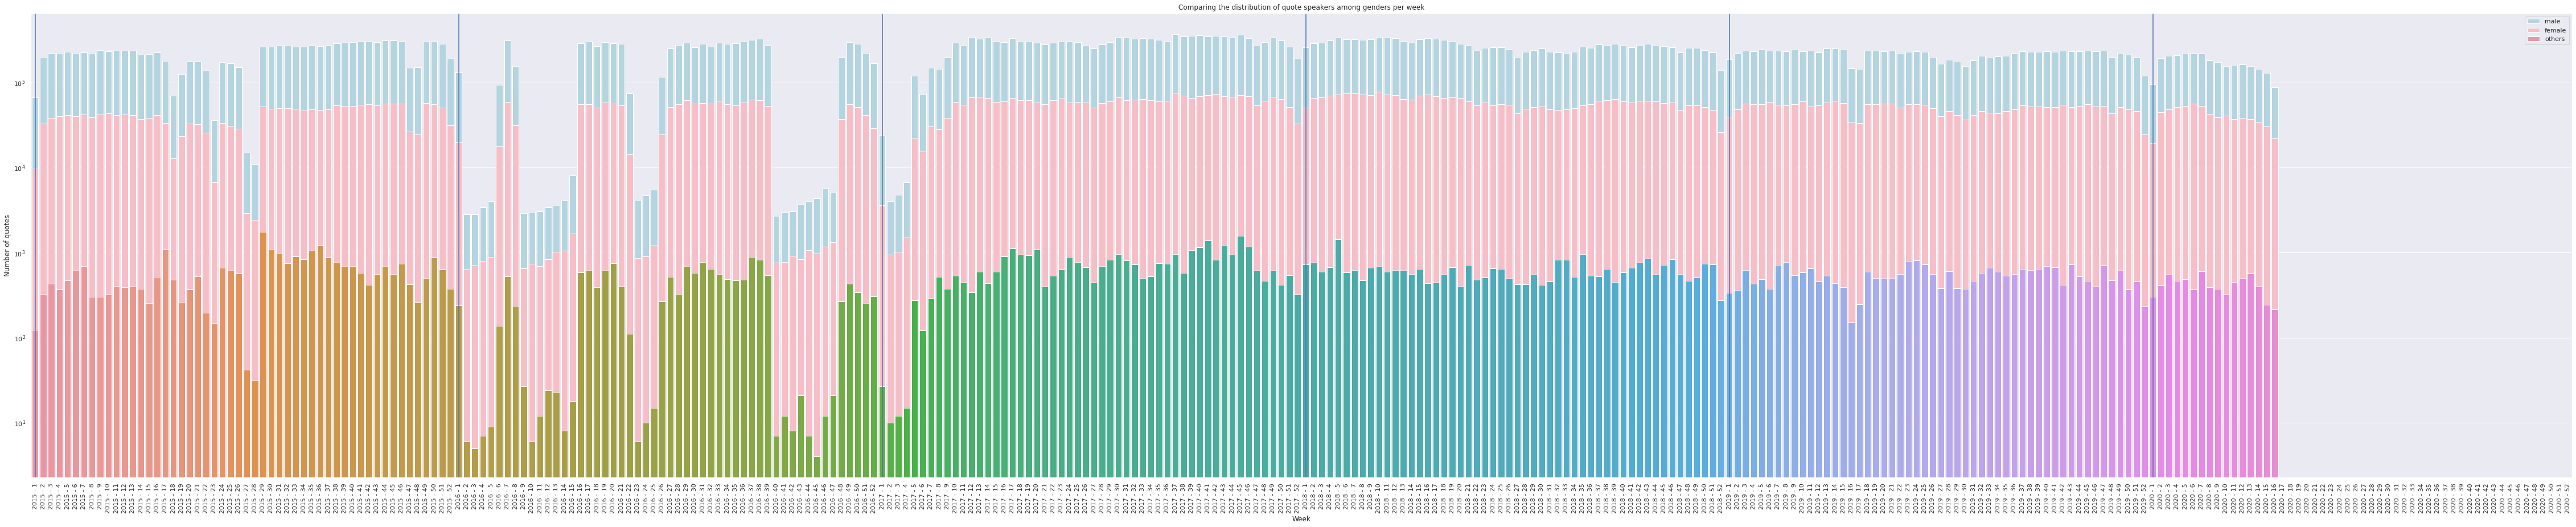

In [ ]:
# Weekly count Quotebank
plot_count_log_scale(plot_df_list[0])

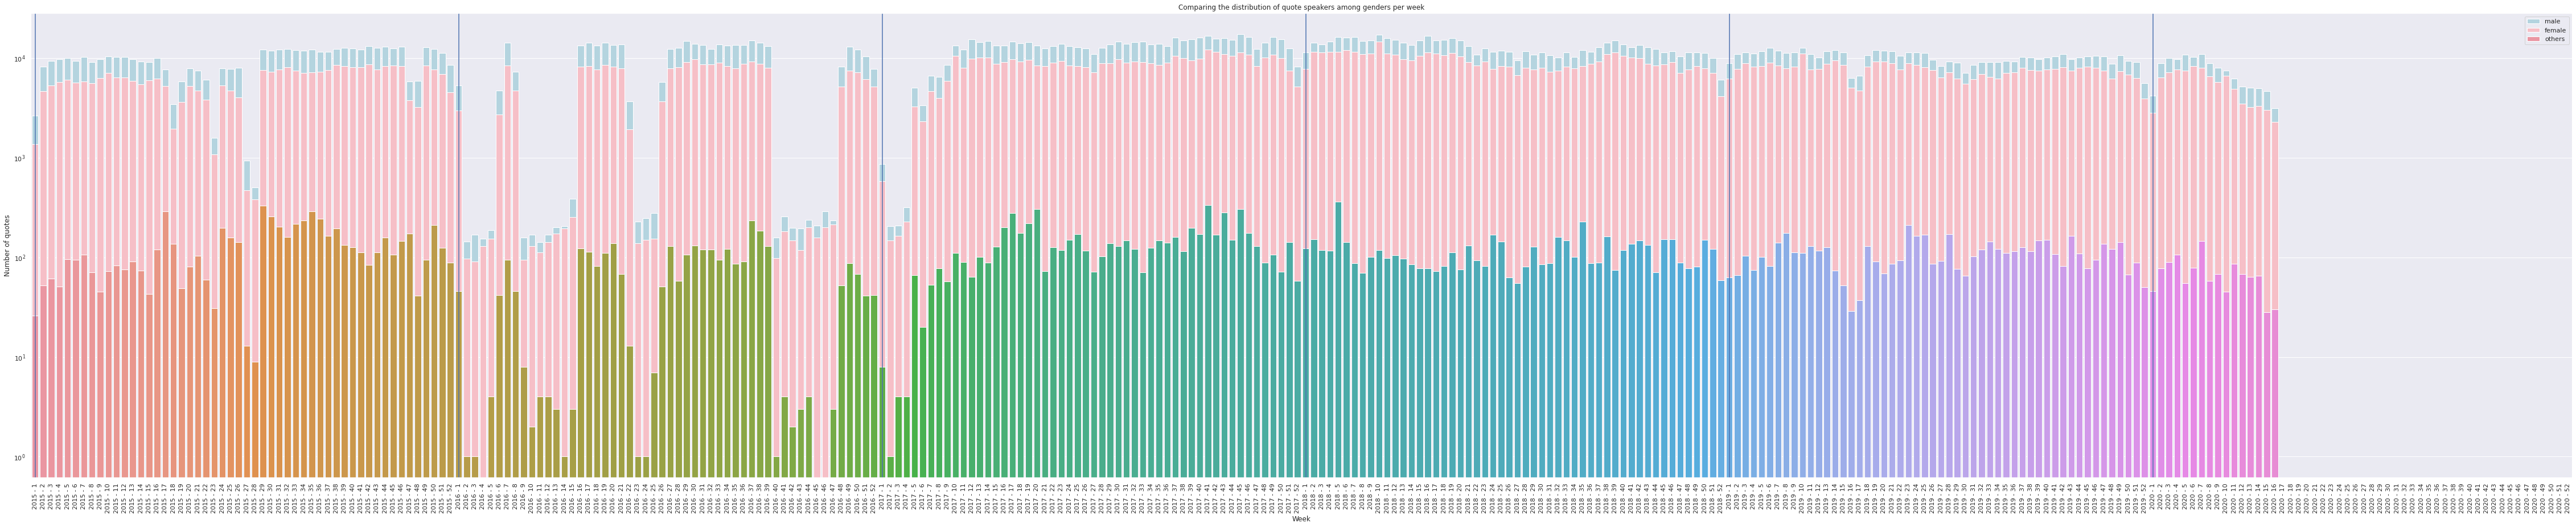

In [ ]:
# Weekly count Women
plot_count_log_scale(plot_df_list[1])

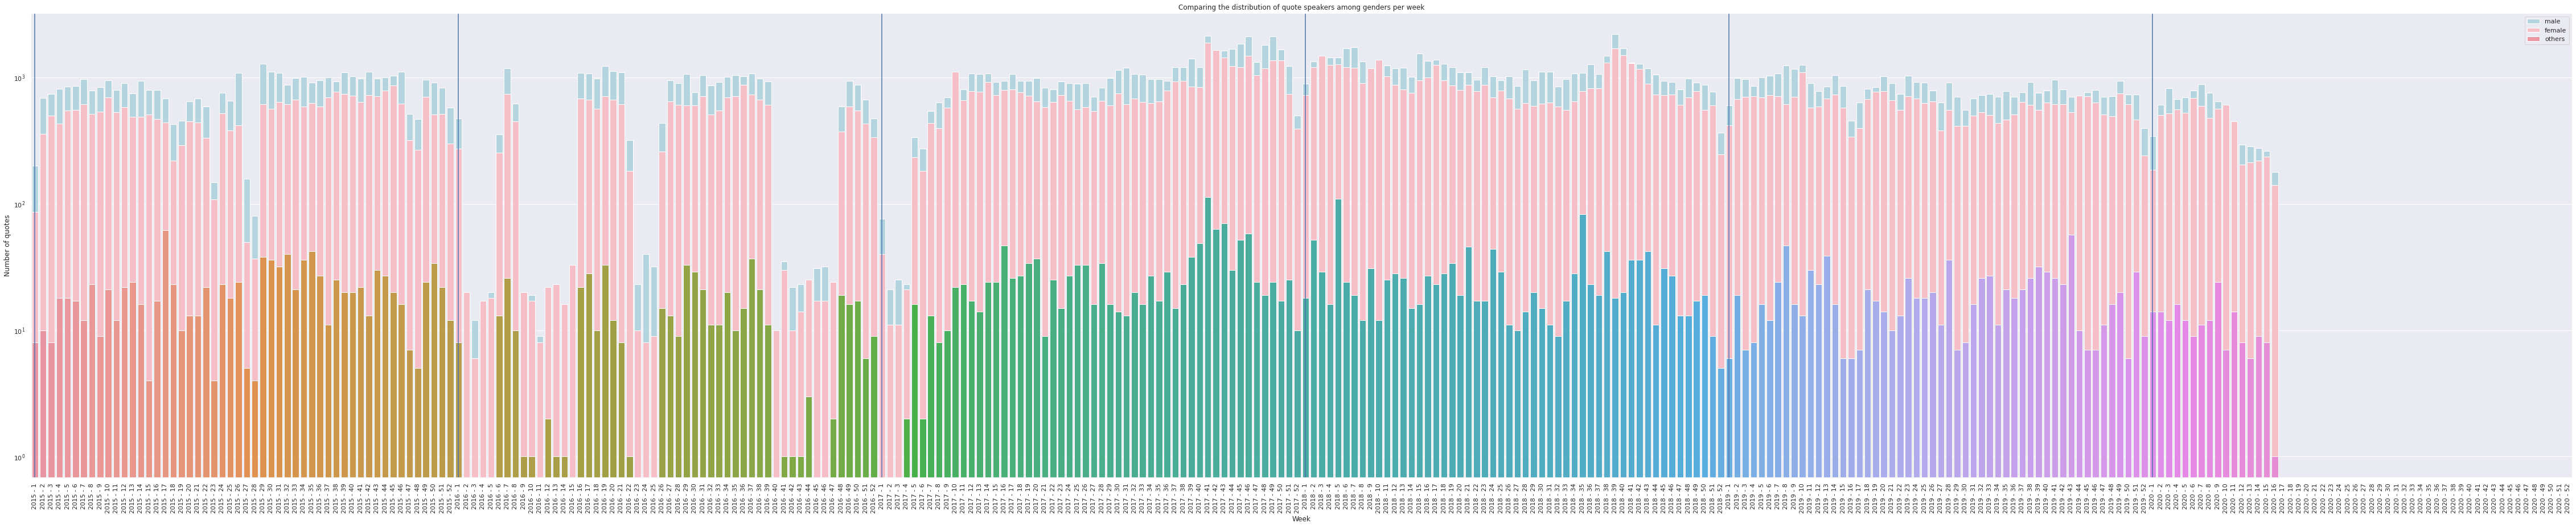

In [ ]:
# Weekly count MeToo
plot_count_log_scale(plot_df_list[2])

TODO On those logarithmic-scale plots, we can clearly see the difference in the importance of each gender in media. The distribution of men and women speakers through time is roughly the same (see correlation below). However, for LGBT+ (other) speakers, they are rarer and seem to speak in peaks which might be correlated with events that happened that week.

### b) Weekly percentage

In [ ]:
# PLOT weekly count with percentage (men - women)
def plot_count_lin_scale(df):
    plt.rcParams['figure.figsize'] = (80,15)
    # Vertical line to separate years
    plt.axvline(x=0) # 2015
    plt.axvline(x=52) # 2016
    plt.axvline(x=52*2) # 2017
    plt.axvline(x=52*3) # 2018
    plt.axvline(x=52*4) # 2019
    plt.axvline(x=52*5) # 2020
    
    ax = sns.barplot(x=df.index, y=df.male,   label='male',   color='lightblue')
    ax = sns.barplot(x=df.index, y=df.female, label='female', color='lightpink')
    ax2 = ax.twinx()
    
    ax2 = sns.lineplot(data=df.male/(df.male+df.female)) # can not directly take df.percent_male as week53 is summed with week1
    ax2 = sns.lineplot(data=df.female/(df.male+df.female))
    
    plt.xticks(rotation=90) #TODO:do not work...??
    plt.xlabel('Week')
    plt.ylabel('Number of quotes')
    plt.title('Comparing the distribution of quote speakers among genders per week')
    plt.rcParams['figure.figsize'] = (80,7)
    plt.show()

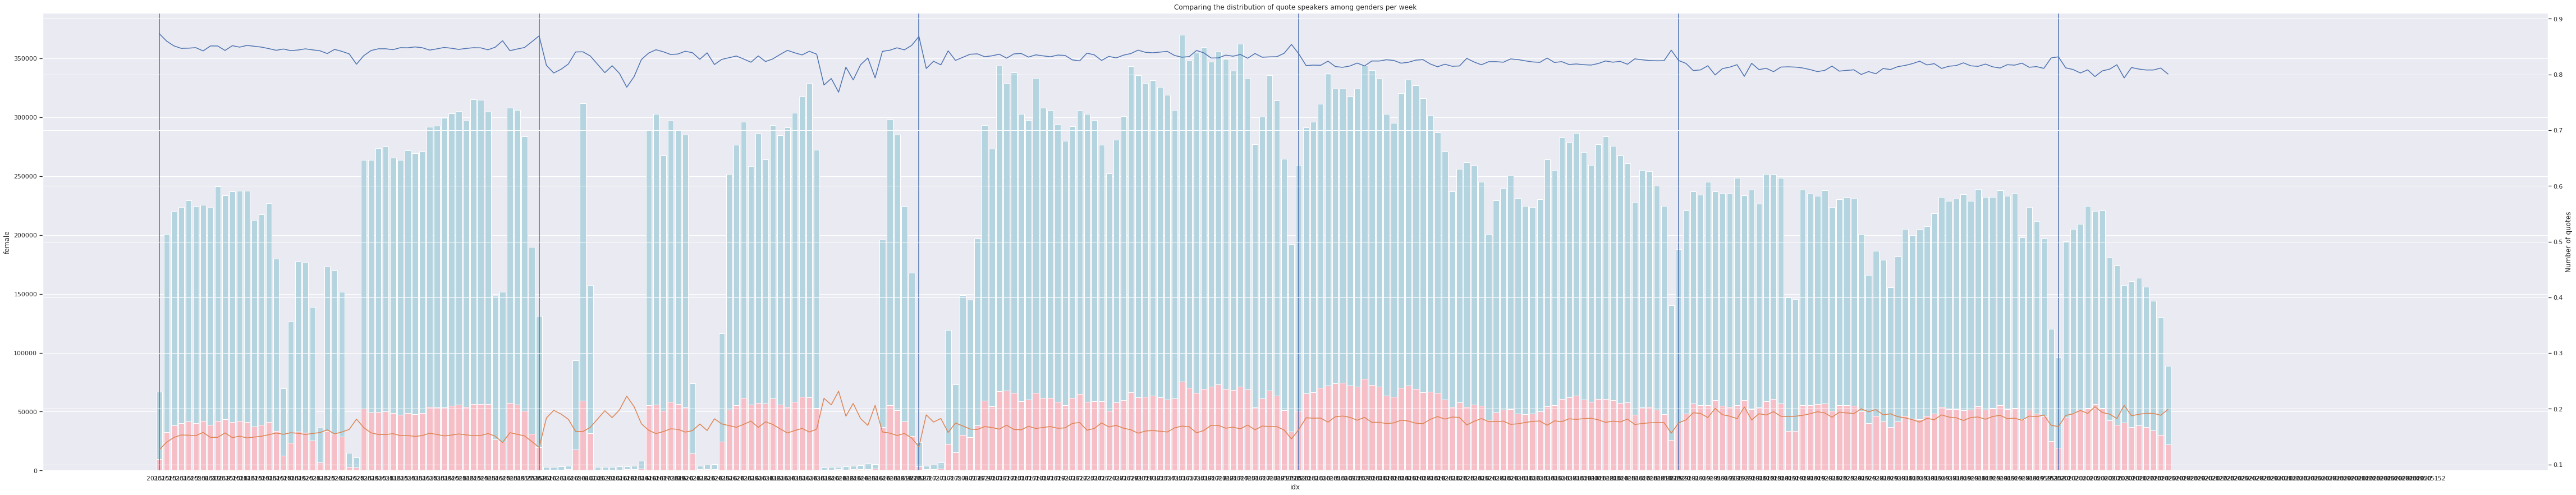

In [ ]:
# Weekly count MeToo
plot_count_lin_scale(plot_df_list[0])

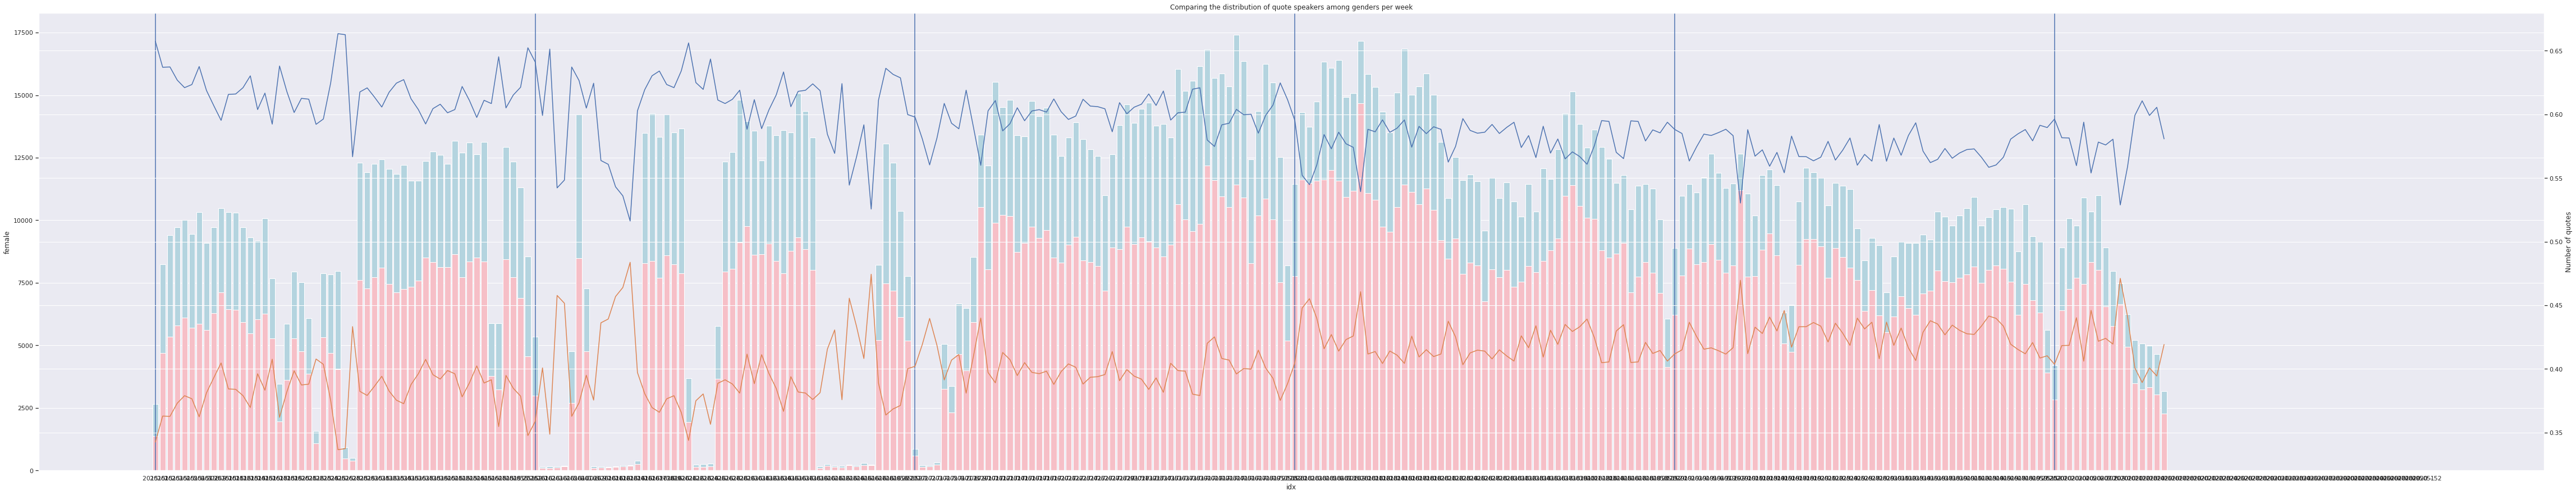

In [ ]:
# Weekly count MeToo
plot_count_lin_scale(plot_df_list[1])

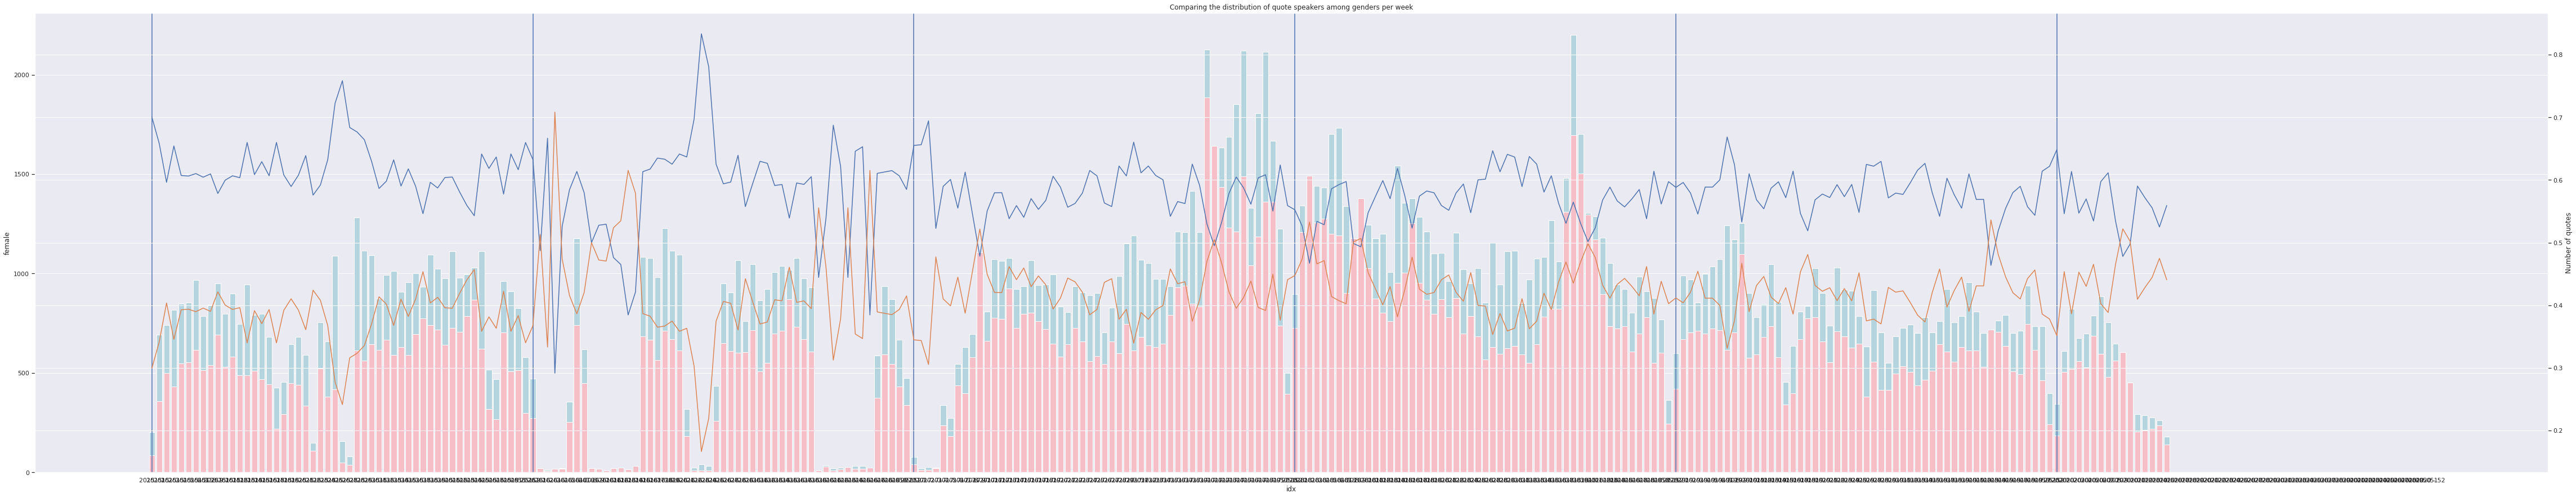

In [ ]:
# Weekly count MeToo
plot_count_lin_scale(plot_df_list[2])

---
## **Step 3:  Generate annual and monthly word clouds based on general women coverage dataset (D2)** <a id="Step-3"> </a>

---
## **Step 4:  Investigate general women perception via general women coverage in medias (D2)** <a id="Step-4"> </a>

In [ ]:
PATH_DATA = './data/data_nlp/'
AD1_FILE = PATH_DATA + 'original_labels.csv'
CHUNK_SIZE = 1000

df = pd.read_csv(AD1_FILE)
df.head(3)

,entry_id,link_id,parent_id,entry_utc,subreddit,author,body,image,label_date,week,group,sheet_order,annotator_id,level_1,level_2,level_3,strength,highlight
0,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",3,Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN
1,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",6,Nonmisogynistic,None_of_the_categories,NaN,NaN,NaN
2,exoxn7,t3_exoxn7,NaN,1580652620,badwomensanatomy,doggodone,Do you have the skin of a 80 year old grandma?...,Yes,17-02-2020,1,1,"(1,)",4,Misogynistic,Derogation,Sexual_or_physical_limitations,Nature of the abuse is Implicit,"skin of a 80 year old grandma? Worry no more, ..."


In [ ]:
df.drop(columns=['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author',
       'label_date', 'week', 'group', 'sheet_order',
       'annotator_id', 'level_2', 'level_3', 'strength',
       'highlight'], inplace=True)

In [ ]:
one_hot = pd.get_dummies(df['level_1'])
df['misogynistic'] = one_hot.Misogynistic.values

In [ ]:
df = df[~df['image'].isin(['Yes'])]
df.drop(['image', 'level_1'], axis=1, inplace=True)
df.dropna(inplace=True)
df = df[~df['body'].isin(['[removed]'])]

In [ ]:
nlp = spacy.load('en_core_web_sm')
punct = string.punctuation

In [ ]:
def remove_url(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r"", text)

def text_data_cleaning(sentence):
    sentence = remove_url(sentence)
    sentence = remove_html(sentence)
    sentence = remove_emoji(sentence)
    doc = nlp(sentence)

    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in nlp.Defaults.stop_words and token not in punct:
            cleaned_tokens.append(token)
    return cleaned_tokens

***TFIDF***

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
tfidf = TfidfVectorizer(tokenizer=text_data_cleaning, ngram_range=(1,2))
classifier = LinearSVC()

In [ ]:
X = df.body
y = df.misogynistic

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [ ]:
X_train.shape, X_test.shape

((12160,), (3040,))

In [ ]:
X_train[1231]

'Bernie is a commie jew....no wonder the sheep masses love him.\n\nI wonder why the system hates him so much...probably because it\'d be too transparent and people , white people, may start to wake up to our genocide if someone who is openly jewish and anti white was elected...\n\nRemember, they are "white" just like us , goyim'

In [ ]:
clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function text_data_cleaning at 0x7fe9db22c9d0>)),
                ('clf', LinearSVC())])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2709
           1       0.72      0.58      0.65       331

    accuracy                           0.93      3040
   macro avg       0.84      0.78      0.80      3040
weighted avg       0.93      0.93      0.93      3040



In [ ]:
confusion_matrix(y_test, y_pred)

array([[2635,   74],
       [ 138,  193]])

In [ ]:
import pickle
filename = './data/data_nlp/classifier2.sav'
pickle.dump(clf, open(filename, 'wb'))

***PREDICTIONS***

In [ ]:
import pickle
clf = pickle.load(open('./data/data_nlp/classifier2.sav', 'rb'))

In [ ]:
year = 2019 # available: from 2015 to 2020
PATH_DATA = './data/data_nlp/predict/'
QUOTES_FILE = PATH_DATA + f'{year}_male.json.bz2'

df = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', typ='frame')


In [ ]:
df['Mysoginistic'] = df.quotation.apply(lambda quote: clf.predict([quote]))

In [ ]:
men_mysoginistic = df[df.Mysoginistic==1]
men_mysoginistic.shape

(56, 12)

In [ ]:
for i, quote in enumerate(men_mysoginistic.quotation):
    print(f'{men_mysoginistic.iloc[i].speaker}: "{quote}"')

Jon Ronson: "Somebody HIV + should rape this bitch."
Mel Gibson: "You look like a f *** ing bitch in heat. And if you get raped by a pack of n **** s it will be your fault. Alright? Because you provoked it. You are provocatively dressed all the time with your fake boobs that you feel you have to show off. I don't like it. I don't want that woman. I don't want you. I don't trust you. I don't love you."
Stanley Ntagali: "We condemn in the strongest term possible, actions of rape and violence against women and girls. As a church, we are deeply concerned about the increasing trend of sexual and gender-based violence in the country especially towards women and girls including the continued harmful practices such as Female Genital Mutilation and child marriages. I am also concerned about the increasing cases of child molesting and defilement and its negative consequences."
Ty Dolla $ ign: "Got too many hoes, I just leave 'em on read / Too much sex, shawty, you can give me head,"
ansel elgort

In [ ]:
year = 2018 # available: from 2015 to 2020
PATH_DATA = './data/data_nlp/predict/'
QUOTES_FILE = PATH_DATA + f'{year}_male.json.bz2'

df = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', typ='frame')


In [ ]:
df['Mysoginistic'] = df.quotation.apply(lambda quote: clf.predict([quote]))

In [ ]:
men_mysoginistic = df[df.Mysoginistic==1]
men_mysoginistic.shape

(86, 12)

In [ ]:
for i, quote in enumerate(men_mysoginistic.quotation):
    print(f'{men_mysoginistic.iloc[i].speaker}: "{quote}"')

Alex Hall: "Feminism causes women to hate men, kill their children, become witches, whores & lesbians."
Kanye West: "feels like [ me ] and Taylor might still have sex/I made that bitch famous,"
Snoop Dogg: "I don't give a fuck about how sexy you think the bitch look. That's a fucking doll, nigga."
Sheikh Mohammed: "The ministry is offering its courses to both sexes, not only to girls. The success of a marital relationship is the responsibility of both women and men. Limiting premarital courses to girls gives the impression that they are responsible for the high divorce rates."
Frank Partnoy: "women were called lapdogs, bitches, and whores. Male brokers groped women, demanded sex, and gave women genital-shaped food. At Merrill Lynch, women were humiliated by strippers at office parties.... At Lew Lieberbaum, there were strippers, cat calls, and demands for oral sex."
Joe Budden: "I should have sex in the coffin `cause I'm killin' these hoes."
Alex Jones: "sexual acts that can kill you."

---
## **Step 5:  Investigate gender and generational biases in general women coverage using NLP (D2)** <a id="Step-5"> </a>

### ***Compute sentiment and age for D1 and D2***

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
sia = SentimentIntensityAnalyzer()
age_limite1 = 40
age_limite2 = 60
compound_limite = 0.05

years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        begin_year = time()
        data_path = path.format(year)
        print("processing path:", data_path[19:])
        reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        i = 0
        for chunk in reader:
            begin_chunk = time()
            chunk = chunk.filter(items=quote_column)

            # remove unknown speaker
            q_is_speaker_None = chunk.speaker=='None' # Checker auusi pou les NaN -> isna()
            q_speaker         = chunk[-q_is_speaker_None].copy()
            q_speaker['qid'] = q_speaker.qids.apply(lambda x: x[0]) # 1st homonym
            q_speaker = q_speaker.drop(columns=['qids'])
            q_speaker = q_speaker.merge(df_selected_parquet, left_on='qid', right_on='id', how='left')

            # age
            q_is_speaker_DOB = q_speaker.date_of_birth.notna()
            q_speaker        = q_speaker[q_is_speaker_DOB]
            q_speaker['age']     = q_speaker.date_of_birth.apply(lambda x: year - int(x[0][1:5])) # we consider speaker is born the 01/01/XXXX - and article of year YYYY have been published the 01/01/YYYY
            q_speaker['age_cat'] = q_speaker.age.apply(lambda x: '0_40' if x <= age_limite1 else '41_60' if x <= age_limite2 else '61_inf')

            # sentiment
            q_speaker['compound']  = q_speaker.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])
            q_speaker['sentiment'] = q_speaker.compound.apply(lambda x: 'neg' if x <= -compound_limite else 'neu' if x <= compound_limite else 'pos')
            
            # drop unused column
            q_speaker.drop(columns=['date_of_birth','id'], inplace=True)
            
            # record result
            new_file_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
            with bz2.open(new_file_path, 'ab') as file: ## Need to delete existing file as open in "Append" mode   --> !!! !!! !!! <--
                q_speaker.to_json(file, orient='records', lines=True)
            print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
            i += 1
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

### ***Compute mean compound per gender*** 

In [ ]:
years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        begin_year = time()
        data_path = path.format(year)
        data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
        print("processing path:", data_path[19:])
        reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        i = 0
        for chunk in reader:
            begin_chunk = time()

            chunk_is_gender = chunk.gender.notna()
            chunk = chunk[chunk_is_gender]
            chunk['gender'] = chunk.gender.apply(lambda x: x[0])
            q_male_female   = chunk[chunk.gender.isin(qid_male+qid_female)].copy()
            q_male_female.gender.replace([qid_male[0], qid_female[0]],['male','female'], inplace=True)
            
            # general : count and avg compound per gender per age_cat
            male_female_mean = q_male_female[['gender', 'age_cat', 'compound']].groupby(['gender','age_cat']).agg({'sum', 'count', 'std'})
            male_female_mean = male_female_mean.droplevel(0, axis=1) # drop "compounds" primary index
            # to compute the average std later (pooled variation)
            male_female_mean['std'] = male_female_mean['std']*male_female_mean['count']
            
            # detailed : count and agv compound per gender per age_cat per sentiment
            male_female = q_male_female[['gender', 'age_cat','sentiment', 'compound']].groupby(['sentiment','age_cat','gender']).agg({'sum', 'count', 'std'})
            male_female = male_female.droplevel(0, axis=1) # drop "compounds" primary index
            # to compute the average std later (pooled variation)
            male_female['std'] = male_female['std']*male_female['count']
            
            if i==0:
                df_compound_count_detail = male_female.copy()
                df_compound_count_general= male_female_mean.copy()
            else:
                df_compound_count_detail = df_compound_count_detail.add(male_female, fill_value=0)
                df_compound_count_general = df_compound_count_general.add(male_female_mean, fill_value=0)
            print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
            i += 1
        
        # general
        df_compound_count_general['mean'] = df_compound_count_general['sum']/df_compound_count_general['count']
        df_compound_count_general['std']  = df_compound_count_general['std']/df_compound_count_general['count']
        df_compound_count_general.drop(columns=['sum'], inplace=True)
        new_file_path_general = data_path[:-9] + '_compounds_per_gender_age' + data_path[-9:]
        with bz2.open(new_file_path_general, 'wb') as file:
            df_compound_count_general.reset_index().to_json(file, orient='records', lines=True)
                
        # detailed
        df_compound_count_detail['mean'] = df_compound_count_detail['sum']/df_compound_count_detail['count']
        df_compound_count_detail['std']  = df_compound_count_detail['std']/df_compound_count_detail['count']
        df_compound_count_detail.drop(columns=['sum'], inplace=True)
        new_file_path_detail = data_path[:-9] + '_compounds_per_gender_age_sentiment' + data_path[-9:]
        with bz2.open(new_file_path_detail, 'wb') as file:
            df_compound_count_detail.reset_index().to_json(file, orient='records', lines=True)
        
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

### ***Compounds for specific Date (women's day and #MeToo tweet)*** 

In [ ]:
import datetime

years = range(2015, 2020+1)
CHUNK_SIZE = 1e5

dates=[(8,3),   # Women-'s Day
       (15,10)] # #MeToo tweet

data_paths = [path_quote_women, path_quote_metoo]
begin_total = time()
for path in data_paths:
    for year in years:
        for date in dates:
            begin_year = time()
            day = date[0]
            month = date[1]
            data_path = path.format(year)
            data_path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
            print("processing path:", data_path[19:])
            reader = pd.read_json(data_path, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
            i = 0
            for chunk in reader:
                begin_chunk = time()

                chunk_is_gender = chunk.gender.notna()
                chunk = chunk[chunk_is_gender]
                chunk['gender'] = chunk.gender.apply(lambda x: x[0])
                q_male_female   = chunk[chunk.gender.isin(qid_male+qid_female)].copy()
                q_male_female.gender.replace([qid_male[0], qid_female[0]],['male','female'], inplace=True)

                # Keep only quotes which are close to selected date
                date_event_begin = datetime.datetime(year, month, day)
                date_event1_end = datetime.datetime(year, month, day+4)
                is_consider = (q_male_female.date>=date_event_begin) & (q_male_female.date<=date_event1_end)
                q_male_female = q_male_female[is_consider]

                # general : count and avg compound per gender per age cat
                male_female_mean = q_male_female[['gender', 'age_cat', 'compound']].groupby(['gender','age_cat']).agg({'sum', 'count', 'std'})
                male_female_mean = male_female_mean.droplevel(0, axis=1)
                male_female_mean['std'] = male_female_mean['std']*male_female_mean['count']
                
                
                # detailed : count and agv compound per gender per age cat per sentiment
                male_female = q_male_female[['gender', 'age_cat','sentiment', 'compound']].groupby(['sentiment','age_cat','gender']).agg({'sum', 'count', 'std'})
                male_female = male_female.droplevel(0, axis=1)
                male_female['std'] = male_female['std']*male_female['count']
                

                if i==0:
                    df_compound_count_detail = male_female.copy()
                    df_compound_count_general= male_female_mean.copy()
                else:
                    df_compound_count_detail = df_compound_count_detail.add(male_female, fill_value=0)
                    df_compound_count_general = df_compound_count_general.add(male_female_mean, fill_value=0)
                print(f"\tchunk {i+1} done in {(time()-begin_chunk):.1f} [s]")
                i += 1

            # general : count and avg compound per gender per age cat
            df_compound_count_general['mean'] = df_compound_count_general['sum']/df_compound_count_general['count']
            df_compound_count_general['std']  = df_compound_count_general['std']/df_compound_count_general['count']
            df_compound_count_general.drop(columns=['sum'], inplace=True)
            new_file_path_general = data_path[:-9] + f'_compounds_per_gender_age_{day}_{month}' + data_path[-9:]
            with bz2.open(new_file_path_general, 'wb') as file:
                df_compound_count_general.reset_index().to_json(file, orient='records', lines=True)

            # detailed
            df_compound_count_detail['mean'] = df_compound_count_detail['sum']/df_compound_count_detail['count']
            df_compound_count_detail['std']  = df_compound_count_detail['std']/df_compound_count_detail['count']
            df_compound_count_detail.drop(columns=['sum'], inplace=True)
            new_file_path_detail = data_path[:-9] + f'_compounds_per_gender_age_sentiment_{day}_{month}' + data_path[-9:]
            with bz2.open(new_file_path_detail, 'wb') as file:
                df_compound_count_detail.reset_index().to_json(file, orient='records', lines=True)
        
        print(f"\t--> year {year} done in {(time()-begin_year):.1f} [s]\n")
print(f'datasets created in {(time() - begin_total):.1f} [s]')

In [ ]:
from compound_analysis import generate_barplot

datasets = ['women', 'metoo']
years = [2015, 2017, 2019]
PATH_DATA = './data/data_nlp/compound/'

generate_barplot(PATH_DATA, datasets, years)

---
## **Step 6:  Investigate gender and generational biases in MeToo coverage using NLP (D1)** <a id="Step-6"> </a>

---
## **Step 7:  Correlate and investigate causation between MeToo general perception and women’s mediatic place** <a id="Step-7"> </a>

## T-Test

In [ ]:
# create Dataset for T-test on compounds
years_t_Test = [2015, 2017, 2019]
df_list_compounds = []

for year in years_t_Test:
    data_path = path_quote_women.format(year)
    path = data_path[:-9] + '_sentiment_age' + data_path[-9:]
    df = pd.read_json(path, lines=True)[['gender','age_cat','compound', 'sentiment']]
    df_is_gender = df.gender.notna()
    df = df[df_is_gender]
    df['gender'] = df.gender.apply(lambda x: x[0])
    df_male_female   = df[df.gender.isin(qid_male+qid_female)].copy()
    df_male_female.gender.replace([qid_male[0], qid_female[0]],['male','female'], inplace=True)
    df_list_compounds.append(df_male_female)

In [ ]:
# one element per year
male_per_age_lst     = [[],[],[]] # one list per age category
female_per_age_lst   = [[],[],[]]

for i, _ in enumerate(years_t_Test):
    # df per year
    df = df_list_compounds[i]
    # mask per category
    mask_male   = df.gender=='male'
    mask_female = df.gender=='female'
    mask_0_40   = df.age_cat=='0_40'
    mask_41_60  = df.age_cat=='41_60'
    mask_61_inf = df.age_cat=='61_inf'
    # add to list
    male_per_age_lst[0].append(df[mask_male & mask_0_40])
    male_per_age_lst[1].append(df[mask_male & mask_41_60])
    male_per_age_lst[2].append(df[mask_male & mask_61_inf])
    female_per_age_lst[0].append(df[mask_female & mask_0_40])
    female_per_age_lst[1].append(df[mask_female & mask_41_60])
    female_per_age_lst[2].append(df[mask_female & mask_61_inf])

In [ ]:
# T-test: for Male
p_male = [[],[],[]] # 1st dim: per age category  -      0_40       |       41_60      |      61_inf
                    # 2dn dim: year comparaison  - (2015 vs 2017)  |  (2017 vs 2019)  |  (2015 vs 2019)
                    # exemple : p_male[1][0] is male_41_60, 2015 vs 2017
for i,male in enumerate(male_per_age_lst):
    for j, _ in enumerate(years_t_Test):
        first_year = j
        second_year = first_year%(len(years_t_Test)-1)+1
        p_male[i].append(stats.ttest_ind(male[first_year].compound, male[second_year].compound))
        
# Print Result        
print('   age   |  2015 vs 2017  |  2017 vs 2019  |  2015 vs 2019  |',
      '-'*61,
      ' 0 -> 40 |' + ' '*6 + f'{p_male[0][0].pvalue:.2g}'+' '*6+'|'+ ' '*6 + f'{p_male[0][1].pvalue:.2g}'+' '*6+'|'+ ' '*6 + f'{p_male[0][2].pvalue:.2g}'+' '*6+'|',
      '41 -> 60 |' + ' '*6 + f'{p_male[1][0].pvalue:.2g}'+' '*4+'|'+ ' '*6 + f'{p_male[1][1].pvalue:.2g}'+' '*5+'|'+ ' '*6 + f'{p_male[1][2].pvalue:.2g}'+' '*5+'|',
      '61 -> ++ |' + ' '*6 + f'{p_male[2][0].pvalue:.2g}'+' '*6+'|'+ ' '*5 + f'{p_male[2][1].pvalue:.2g}'+' '*4+'|'+ ' '*5 + f'{p_male[2][2].pvalue:.2g}'+' '*4+'|',
      sep='\n')

   age   |  2015 vs 2017  |  2017 vs 2019  |  2015 vs 2019  |
-------------------------------------------------------------
 0 -> 40 |      0.44      |      0.44      |      0.44      |
41 -> 60 |      0.0018    |      0.042     |      0.042     |
61 -> ++ |      0.44      |     3.6e-07    |     3.6e-07    |


In [ ]:
# T-test: for Female
p_female = [[],[],[]] # same as for p_male
for i,female in enumerate(female_per_age_lst):
    for j, _ in enumerate(years_t_Test):
        first_year = j
        second_year = first_year%(len(years_t_Test)-1)+1
        p_female[i].append(stats.ttest_ind(female[first_year].compound, female[second_year].compound))
        
# Print Result
print('   age   |  2015 vs 2017  |  2017 vs 2019  |  2015 vs 2019  |',
      '-'*61,
      ' 0 -> 40 |' + ' '*4 + f'{p_female[0][0].pvalue:.2g}'+' '*5+'|'+ ' '*5 + f'{p_female[0][1].pvalue:.2g}'+' '*4+'|'+ ' '*4 + f'{p_female[0][2].pvalue:.2g}'+' '*5+'|',
      '41 -> 60 |' + ' '*4 + f'{p_female[1][0].pvalue:.2g}'+' '*5+'|'+ ' '*5 + f'{p_female[1][1].pvalue:.2g}'+' '*4+'|'+ ' '*4 + f'{p_female[1][2].pvalue:.2g}'+' '*5+'|',
      '61 -> ++ |' + ' '*6 + f'{p_female[2][0].pvalue:.2g}'+' '*6+'|'+ ' '*5 + f'{p_female[2][1].pvalue:.2g}'+' '*4+'|'+ ' '*4 + f'{p_female[2][2].pvalue:.2g}'+' '*5+'|',
      sep='\n')

   age   |  2015 vs 2017  |  2017 vs 2019  |  2015 vs 2019  |
-------------------------------------------------------------
 0 -> 40 |    9.8e-05     |     2.5e-22    |    2.5e-22     |
41 -> 60 |    7.7e-12     |     2.1e-25    |    2.1e-25     |
61 -> ++ |      0.71      |     0.00023    |    0.00023     |
